# Clustering 
1. Hierarchical clustering
2. K-means clustering
3. DBScanner clustering

#### Importing necessary libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns 


### Hierarchical clustering 

#### Load dataset and use .head() to view the first 6 rows of the dataset

In [6]:
df = pd.read_csv('Processed_Data.csv')
print(df.head(6))

  customer_id  customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e             2360          18.0             2              5   
1  5d272b9dcb             8670          17.0             2              2   
2  f6d1b2ba63             4660          38.0             1              2   
3  180c632ed8             4660          26.0             2              3   
4  4eb37a6705             4660          20.0             2              5   
5  6aef2b6726             8670          40.0             2              2   

   is_chain  first_order  last_order last_promo payment_method  ...  HR_22  \
0         1            0           1   DELIVERY           DIGI  ...      0   
1         2            0           1   DISCOUNT           DIGI  ...      0   
2         2            0           1   DISCOUNT           CASH  ...      0   
3         1            0           2   DELIVERY           DIGI  ...      0   
4         0            0           2   No promo           DIGI  ...   

#### Separate numerical and categorical features
To handle mixed data types we have to seperate numerical and categorical features

In [9]:
numerical_features = [
    'customer_age', 'vendor_count', 'product_count',
] + [f'DOW_{i}' for i in range(7)] + [f'HR_{i}' for i in range(24)] + \
[col for col in df.columns if col.startswith('CUI_')]

categorical_features = ['customer_region', 'is_chain']

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['customer_age', 'vendor_count', 'product_count', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai']
Categorical Features: ['customer_region', 'is_chain']


Handeling possible mussing values

In [43]:
# Fill missing values for numerical features with the mean
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# Fill missing values for categorical features with the mode
for feature in categorical_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])


### Preprocess Data

##### Numerical varibles

1. Scale numerical features using StandardScaler
2. Encoding categorical features using One-Hot Encoding

In [15]:
1. 
scaler = StandardScaler()
data_scaled_numerical = scaler.fit_transform(df[numerical_features])

# Convert back to a DataFrame for easier handling
data_scaled_numerical = pd.DataFrame(data_scaled_numerical, columns=numerical_features)

In [17]:
2. 
data_encoded_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Check the transformed categorical data
print("One-Hot Encoded Categorical Features:")
print(data_encoded_categorical.head())

One-Hot Encoded Categorical Features:
   customer_region  is_chain
0             2360         1
1             8670         2
2             4660         2
3             4660         1
4             4660         0


#### Combine processed data: numerical and categorical

In [18]:
# Combine numerical and categorical data
data_preprocessed = pd.concat([data_scaled_numerical, data_encoded_categorical], axis=1)

# Confirm the shape of the processed data
print(f"Preprocessed Data Shape: {data_preprocessed.shape}")


Preprocessed Data Shape: (31875, 51)


## Linkage Matrix

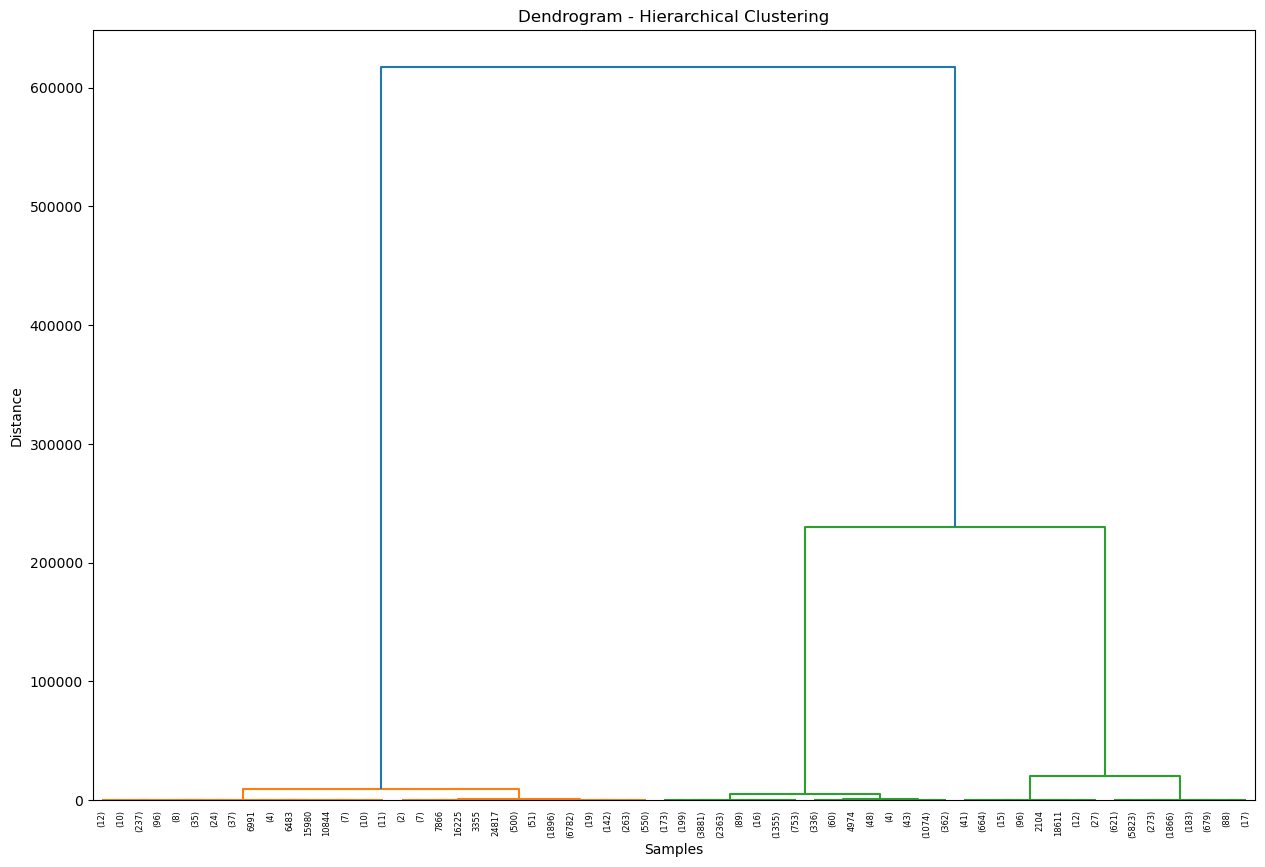

In [22]:
# Build the linkage matrix using Euclidean distance
linkage_matrix = linkage(data_preprocessed, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Show the top 5 levels
plt.title("Dendrogram - Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


### Observations from the Dendrogram

1. **Number of Clusters**:
   - There is a significant jump at the 600,000 distance mark, suggesting that **2 main clusters** could be formed.
   - If more granularity is needed, cutting at a lower distance (e.g., 200,000) could result in **4 smaller clusters**.

2. **Cluster Compactness**:
   - The smaller branches at the bottom of the dendrogram indicate **tight, similar groups** within clusters.
   - The larger distances between the green and orange branches show **clear separation** between the two main clusters.

3. **Hierarchical Relationships**:
   - The hierarchy reveals **subgroups within each main cluster**, which could be further explored if additional detail is required.

### Conclusion
- Start with **2 clusters** for broader analysis.
- Explore **4 clusters** for more detailed segmentation if necessary.


#### Decide the number oof clusters based on the dendrogram above

In [26]:
# Decide the number of clusters (e.g., 4)
num_clusters = 4

# Generate cluster labels
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Add cluster labels to the original dataset
df['cluster'] = clusters


### analyze clusters

In [31]:
# Analyze numerical features by cluster
cluster_profiles_numerical = df.groupby('cluster')[numerical_features].mean()

print("Cluster Profiles - Numerical Features:")
print(cluster_profiles_numerical)


Cluster Profiles - Numerical Features:
         customer_age  vendor_count  product_count     DOW_0     DOW_1  \
cluster                                                                  
1           27.471011      2.867986       4.817664  0.485482  0.481468   
2           27.449010      3.685135       6.581854  0.658641  0.676118   
3           27.607935      1.803967       4.192532  0.347725  0.355893   
4           27.490681      2.824607       5.726178  0.537906  0.560838   

            DOW_2     DOW_3     DOW_4     DOW_5     DOW_6  ...  CUI_Chinese  \
cluster                                                    ...                
1        0.491551  0.490430  0.487816  0.518252  0.539632  ...     1.142122   
2        0.695082  0.718323  0.766385  0.765362  0.847355  ...     2.593849   
3        0.415403  0.423571  0.596266  0.480747  0.581097  ...     0.217316   
4        0.600838  0.670157  0.798639  0.692880  0.739267  ...     0.556768   

         CUI_Desserts  CUI_Healthy  CUI_I

In [39]:
# Analyze categorical features by cluster
categorical_cluster_profiles = {}
for feature in categorical_features:
    proportions = df.groupby('cluster')[feature].value_counts(normalize=True).unstack()
    categorical_cluster_profiles[feature] = proportions

# Display cluster profiles for categorical features
for feature, profile in categorical_cluster_profiles.items():
    print(f"\nCluster Profiles for Categorical Feature: {feature}")
    print(profile)



Cluster Profiles for Categorical Feature: customer_region
customer_region      2360      2440      2490  4140  4660      8370      8550  \
cluster                                                                         
1                     NaN       NaN       NaN   NaN   NaN  0.046214  0.001214   
2                0.820768  0.137864  0.041368   NaN   NaN       NaN       NaN   
3                     NaN       NaN       NaN   1.0   NaN       NaN       NaN   
4                     NaN       NaN       NaN   NaN   1.0       NaN       NaN   

customer_region      8670  
cluster                    
1                0.952572  
2                     NaN  
3                     NaN  
4                     NaN  

Cluster Profiles for Categorical Feature: is_chain
is_chain        0         1         2         3         4         5   \
cluster                                                                
1         0.236953  0.332275  0.195407  0.105312  0.050509  0.028475   
2         0.039509

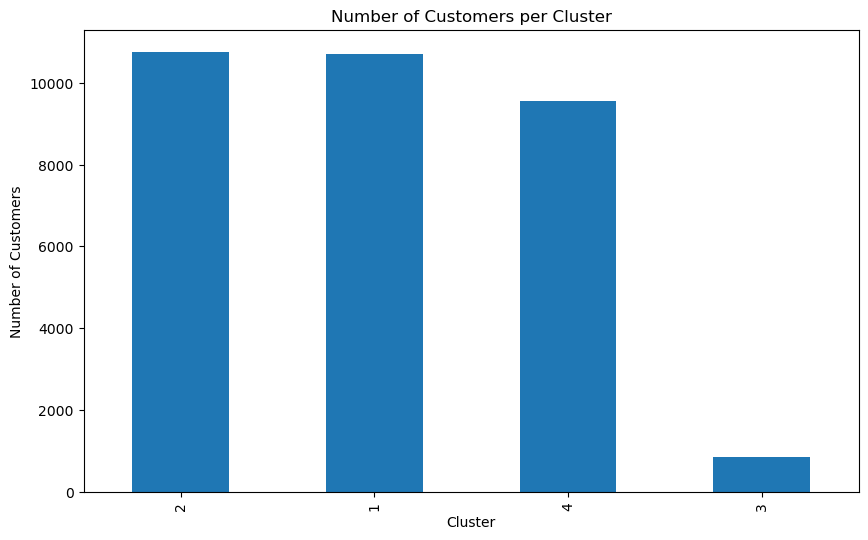

In [35]:
# Distribution of customers across clusters
df['cluster'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


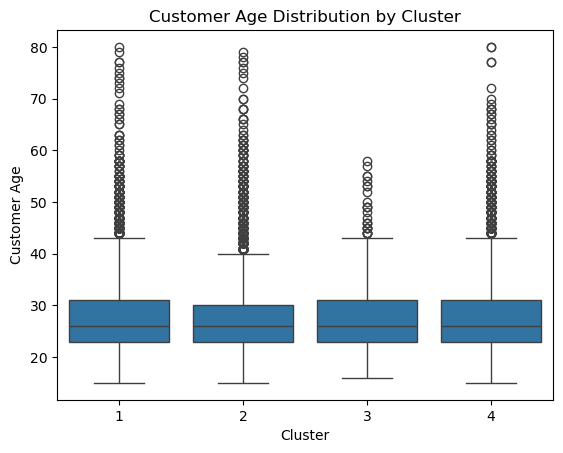

In [37]:
# Boxplot for customer age by cluster
sns.boxplot(x='cluster', y='customer_age', data=df)
plt.title("Customer Age Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Age")
plt.show()
